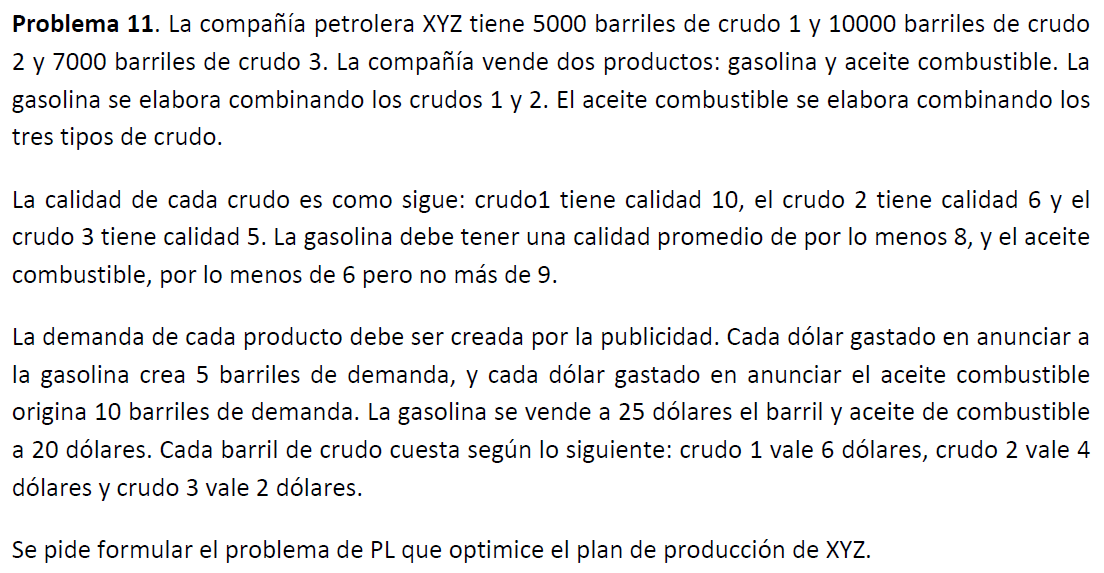

## Sets
I es el conjunto de crudos (i = 1 es el crudo 1, i = 2 es el crudo 2, i = 3 es el crudo 3)\
J es el conjunto de combustibles (j = 1 es gasolina, j = 2 es aceite)

In [17]:
import pyomo.environ as pe
import pyomo.opt as po

In [18]:
model = pe.ConcreteModel()

In [19]:
model.I = pe.RangeSet(1,3)
model.J = pe.RangeSet(1,2)

## Parameters
Costoi es el costo de compra unitario de barriles del crudo i (dolar/barril)\
Ingresoj es el ingreso unitario por la venta de barriles del combustible j (dolar/barril)\
Dispoi es la cantidad de barriles del crudo i que dispone la compañía (barril)\
CalidadCi es la calidad relativa que debe tener el crudo i (calidad/barril)\
Demj es la cantidad de barriles del combustible j creados por la publicidad (barril/dolar)\
CalMinj es la calidad mínima promedio del combustible j (calidad/barril)\
CalMaxj es la calidad máxima permitida promedio en el combustible j (calidad/barril)

In [20]:
Costo = {1: 6, 2: 4, 3: 2}
Ingreso = {1: 25, 2: 20}
Dispo = {1: 5000, 2: 10000, 3: 7000}
CalidadC = {1: 10, 2: 6, 3: 5}
Dem = {1: 5, 2: 10}
CalMin = {1: 8, 2: 6}
CalMax = {1: 999999999999999999999, 2: 9}

In [21]:
model.Costo = pe.Param(model.I, initialize = Costo) #Costo unitario
model.Ingreso = pe.Param(model.J, initialize = Ingreso) #Ingreso unitario
model.Dispo = pe.Param(model.I, initialize = Dispo) #Barriles disponibles
model.CalidadC = pe.Param(model.I, initialize = CalidadC) #Calidad del crudo
model.Dem = pe.Param(model.J, initialize = Dem) #Demanda de barriles 
model.CalMin = pe.Param(model.J, initialize = CalMin) #Calidad mínima promedio
model.CalMax = pe.Param(model.J, initialize = CalMax) #Calidad máxima promedio

## Variables
xij es la cantidad de barriles del crudo i usados para fabricar el combustible j\
aj son los dólares gastados en anunciar el combustible j

In [22]:
model.x = pe.Var(model.I, model.J, domain = pe.NonNegativeReals)
model.a = pe.Var(model.J, domain = pe.NonNegativeReals)

## Objective

In [23]:
Z = sum((model.Ingreso[j] - model.Costo[i]) * model.x[i,j] for i in model.I for j in model.J) - sum(model.a[j] for j in model.J)
model.objective = pe.Objective(sense = pe.maximize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 19*x[1,1] + 14*x[1,2] + 21*x[2,1] + 16*x[2,2] + 23*x[3,1] + 18*x[3,2] - (a[1] + a[2])


## Constraints

In [24]:
#X31 es 0
X31_lhs = model.x[3,1]
X31_rhs = 0
model.X31 = pe.Constraint(expr = (X31_lhs == X31_rhs))
model.X31.pprint()

X31 : Size=1, Index=None, Active=True
    Key  : Lower : Body   : Upper : Active
    None :   0.0 : x[3,1] :   0.0 :   True


In [25]:
#Dispoción de barriles de crudo
model.dispocion_barril = pe.ConstraintList()
for i in model.I:
    disp_lhs = sum(model.x[i,j] for j in model.J)
    disp_rhs = model.Dispo[i]
    model.dispocion_barril.add(disp_lhs <= disp_rhs)
model.dispocion_barril.pprint()

dispocion_barril : Size=3, Index=dispocion_barril_index, Active=True
    Key : Lower : Body            : Upper   : Active
      1 :  -Inf : x[1,1] + x[1,2] :  5000.0 :   True
      2 :  -Inf : x[2,1] + x[2,2] : 10000.0 :   True
      3 :  -Inf : x[3,1] + x[3,2] :  7000.0 :   True


In [26]:
#Demanda por publicidad 
model.demanda_pub = pe.ConstraintList()
for j in model.J:
    dem_pub_lhs = sum(model.x[i,j] for i in model.I)
    dem_pub_rhs = model.a[j] * model.Dem[j]
    model.demanda_pub.add(dem_pub_lhs == dem_pub_rhs)
model.demanda_pub.pprint()

demanda_pub : Size=2, Index=demanda_pub_index, Active=True
    Key : Lower : Body                               : Upper : Active
      1 :   0.0 :  x[1,1] + x[2,1] + x[3,1] - 5*a[1] :   0.0 :   True
      2 :   0.0 : x[1,2] + x[2,2] + x[3,2] - 10*a[2] :   0.0 :   True


In [27]:
#Calidad mínima promedio
model.cal_crud = pe.ConstraintList()
for j in model.J:
    calcrud_lhs = sum(model.CalidadC[i] * model.x[i,j] for i in model.I)
    calcrud_rhs = model.CalMin[j] * sum(model.x[i,j] for i in model.I)
    model.cal_crud.add(calcrud_lhs >= calcrud_rhs)
model.cal_crud.pprint()

cal_crud : Size=2, Index=cal_crud_index, Active=True
    Key : Lower : Body                                                             : Upper : Active
      1 :  -Inf : 8*(x[1,1] + x[2,1] + x[3,1]) - (10*x[1,1] + 6*x[2,1] + 5*x[3,1]) :   0.0 :   True
      2 :  -Inf : 6*(x[1,2] + x[2,2] + x[3,2]) - (10*x[1,2] + 6*x[2,2] + 5*x[3,2]) :   0.0 :   True


In [28]:
#Calidad máxima promedio
model.cal_crud_max = pe.ConstraintList()
for j in model.J:
    calcrudmax_lhs = sum(model.CalidadC[i] * model.x[i,j] for i in model.I)
    calcrudmax_rhs = model.CalMax[j] * sum(model.x[i,j] for i in model.I)
    model.cal_crud_max.add(calcrudmax_lhs <= calcrudmax_rhs)
model.cal_crud_max.pprint()

cal_crud_max : Size=2, Index=cal_crud_max_index, Active=True
    Key : Lower : Body                                                                               : Upper : Active
      1 :  -Inf : 10*x[1,1] + 6*x[2,1] + 5*x[3,1] - 999999999999999999999*(x[1,1] + x[2,1] + x[3,1]) :   0.0 :   True
      2 :  -Inf :                     10*x[1,2] + 6*x[2,2] + 5*x[3,2] - 9*(x[1,2] + x[2,2] + x[3,2]) :   0.0 :   True


## Solver

In [29]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp24esagy9.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmphzd7l5fz.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp3oh0tsv7.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp3oh0tsv7.pyomo.lp'...
11 rows, 9 columns, 27 non-zeros
84 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmphzd7l5fz.glpk.glp'...
66 lines were written
GLPK Simplex Optimizer 5.0
11 rows, 9 columns, 27 non-zeros
Preprocessing...
5 rows, 5 columns, 11 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (5)
*     5: obj =   3.856500000e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0

In [30]:
for i in model.I:
    for j in model.J:
        print(pe.value(model.x[i,j]))

3250.0
1750.0
3250.0
6750.0
0.0
7000.0


In [31]:
for j in model.J:
    print(pe.value(model.a[j]))

1300.0
1550.0


In [32]:
print(pe.value(model.objective))

385650.0
